## import libraries 

In [19]:
import pandas
import configparser
import psycopg2

In [20]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [21]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

make sure change the schema name to your gp number

In [4]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp12.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [117]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [5]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [27]:
url = 'https://www.trulia.com/MA/Middleton/01949/'

In [28]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))



In [29]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)



## insert the records into database

In [30]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp12.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [31]:
df = pandas.read_sql_query('select * from gp12.house ', conn)
df[:]

,price,bed,bath,area,address
0,349000,3,3,1647,"2844 Cullison Ct, Rockingham, VA 22801"
1,199900,4,1,1285,"786 Foley Rd, Harrisonburg, VA 22801"
2,429000,4,3,2392,"1038 James Pl, Harrisonburg, VA 22801"
3,587000,3,2,2378,"131 Cadogan Ct, Rockingham, VA 22801"
4,255000,2,1,1182,"120 Garbers Church Rd, Harrisonburg, VA 22801"
...,...,...,...,...,...
87,192900,6,5,6049,"Lot-20B Wildmeadow Rd, Boxford, MA 01921"
88,899900,4,4,3084,"208 Rowley Bridge Rd, Topsfield, MA 01983"
89,175000,2,1,1000,"466 Newbury St #22, Danvers, MA 01923"
90,850000,4,4,3080,"9 Pine St, Peabody, MA 01960"


## basic stat

In [32]:
df.describe()

,price,bed,bath,area
count,9.200000e+01,92.000000,92.000000,92.000000
mean,6.786954e+05,3.652174,3.228261,2854.467391
std,5.720922e+05,1.787839,1.840349,1719.925180
min,5.000000e+04,1.000000,1.000000,596.000000
25%,3.292500e+05,3.000000,2.000000,1633.250000
50%,5.525000e+05,3.000000,3.000000,2420.000000
75%,8.500000e+05,4.000000,4.000000,3692.500000
max,3.250000e+06,15.000000,16.000000,8759.000000


## price distribution

<AxesSubplot:>

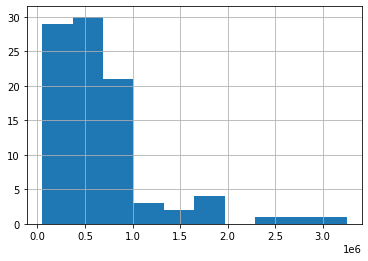

In [33]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

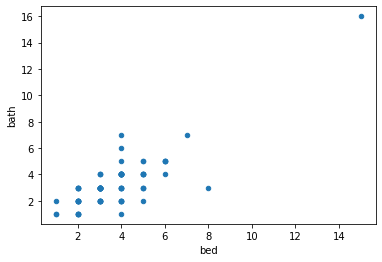

In [34]:
df.plot.scatter(x='bed',y='bath')